<a href="https://colab.research.google.com/github/laxmisuprini/FinalYearProject/blob/master/fire_detect_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6710094960000106
GPU (s):
0.182550722999963
GPU speedup over CPU: 20x


In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
import h5py
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
#for broken data stream error
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
import os
os.chdir("/content/drive/My Drive/Fire_Detect")
!pwd

/content/drive/My Drive/Fire_Detect


In [57]:
!cp /content/drive/My Drive/Datasets /content/FireLab/

cp: cannot stat '/content/drive/My': No such file or directory
cp: cannot stat 'Drive/Datasets': No such file or directory


In [60]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [0]:
!cp -r Datasets /content/FireLab

In [0]:
train_path = '/content/FireLab/Datasets/train'
valid_path = '/content/FireLab/Datasets/valid'
test_path = '/content/FireLab/Datasets/test'

In [64]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=1024)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=256)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=256, shuffle=False)



Found 38659 images belonging to 2 classes.
Found 9666 images belonging to 2 classes.
Found 11830 images belonging to 2 classes.


In [0]:
mobile = keras.applications.mobilenet.MobileNet()


17227776/17225924 [==============================] - 1s 0us/step


In [0]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [0]:
#Deleting the last 5 layers and replacing it with a dense softmax layer consisting of 2 nodes: Fire and Non-fire
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [0]:
model.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [0]:
#Freezing weights all the layers upto the 4th last layer
#This is done because we will retrain only the last three layers
for layer in model.layers[:-4]:
    layer.trainable = False

In [0]:
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/Fire_Detect/my_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001)

In [0]:
model.fit_generator(train_batches, steps_per_epoch=5, 
                    validation_data=valid_batches, validation_steps=5, epochs=3, verbose=1, callbacks=[checkpointer,reduce_lr])

Epoch 1/3


ValueError: ignored

In [0]:
from keras.models import load_model

Test and Accuracy metrics

In [0]:
model = load_model('/content/drive/My Drive/Fire_Detect/fireDetect.h5')

In [70]:
test_labels = test_batches.classes
test_labels
test_batches.class_indices
predictions = model.predict_generator(test_batches, steps=47, verbose=1)

13/47 [=======>......................] - ETA: 55s

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/47 [=======>......................] - ETA: 6:10

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/47 [========>.....................] - ETA: 10:12

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/47 [=========>....................] - ETA: 13:30

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/47 [=========>....................] - ETA: 16:04

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/47 [==========>...................] - ETA: 17:57

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/47 [===========>..................] - ETA: 19:32

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/47 [===========>..................] - ETA: 20:45

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/47 [============>.................] - ETA: 21:39

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/47 [=============>................] - ETA: 22:20

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 22 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/47 [=============>................] - ETA: 22:43

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/47 [==============>...............] - ETA: 22:55

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/47 [==============>...............] - ETA: 22:59

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/47 [===============>..............] - ETA: 22:51

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/47 [================>.............] - ETA: 22:37

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/47 [================>.............] - ETA: 22:11

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/47 [=================>............] - ETA: 21:40

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/47 [==================>...........] - ETA: 21:02

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/47 [==================>...........] - ETA: 20:15

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/47 [===================>..........] - ETA: 19:24

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/47 [====================>.........] - ETA: 18:28

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/47 [====================>.........] - ETA: 17:26

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/47 [=====================>........] - ETA: 16:22

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/47 [=====================>........] - ETA: 15:16

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/47 [======================>.......] - ETA: 14:03

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/47 [=======================>......] - ETA: 12:50

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 38 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/47 [=======================>......] - ETA: 11:34

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/47 [========================>.....] - ETA: 10:15

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/47 [=========================>....] - ETA: 8:53 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/47 [=========================>....] - ETA: 7:29

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/47 [==========================>...] - ETA: 6:03

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)


44/47 [===========================>..] - ETA: 4:35

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 44 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/47 [===========================>..] - ETA: 3:05

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 45 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/47 [==============================] - 4330s 92s/step


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [78]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
test_batches.class_indices

{'fire': 0, 'nonfire': 1}

Confusion matrix, without normalization
[[2943  219]
 [  20 8648]]


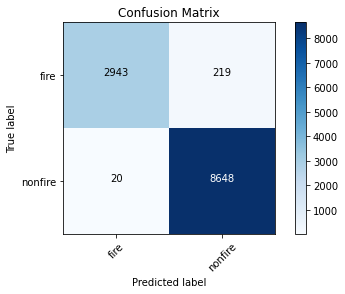

In [79]:
cm_plot_labels = ['fire','nonfire']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')